### loading packages

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import matplotlib as mp
import os
pd.options.display.float_format = '{:.2f}'.format
from prophet import Prophet
from croston import croston
import statsmodels.api as sm
# import plotly
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error,r2_score
from pmdarima.arima.utils import ndiffs
from NBEATS import NeuralBeats
from pandas import DataFrame
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
import calendar
from datetime import timedelta
import datetime as dt
#import time

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### loading dataset

In [2]:
from autots.models.model_list import model_lists

### list of auto ts models

In [3]:
model_lists

{'all': ['ConstantNaive',
  'LastValueNaive',
  'AverageValueNaive',
  'GLS',
  'GLM',
  'ETS',
  'ARIMA',
  'FBProphet',
  'RollingRegression',
  'GluonTS',
  'SeasonalNaive',
  'UnobservedComponents',
  'VECM',
  'DynamicFactor',
  'MotifSimulation',
  'WindowRegression',
  'VAR',
  'DatepartRegression',
  'UnivariateRegression',
  'UnivariateMotif',
  'MultivariateMotif',
  'NVAR',
  'MultivariateRegression',
  'SectionalMotif',
  'Theta',
  'ARDL',
  'NeuralProphet',
  'DynamicFactorMQ',
  'PytorchForecasting',
  'ARCH',
  'RRVAR',
  'MAR',
  'TMF',
  'LATC',
  'KalmanStateSpace',
  'MetricMotif',
  'Cassandra',
  'SeasonalityMotif',
  'MLEnsemble',
  'PreprocessingRegression',
  'FFT',
  'BallTreeMultivariateMotif',
  'TiDE',
  'NeuralForecast'],
 'default': {'ConstantNaive': 1,
  'LastValueNaive': 1,
  'AverageValueNaive': 1,
  'GLS': 1,
  'SeasonalNaive': 1,
  'GLM': 1,
  'ETS': 1,
  'FBProphet': 0.5,
  'GluonTS': 0.5,
  'UnobservedComponents': 1,
  'VAR': 1,
  'VECM': 1,
  'ARI

In [3]:
from autots.datasets import load_monthly
df_raw = load_monthly(long=True)

In [38]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099 entries, 0 to 4098
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     4099 non-null   datetime64[ns]
 1   value        3955 non-null   float64       
 2   series_id    4099 non-null   object        
 3   series_name  4099 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 128.2+ KB


In [39]:
df_raw.describe()

,datetime,value
count,4099,3955.00
mean,1998-05-20 14:25:58.038545920,33.15
min,1953-04-01 00:00:00,0.25
25%,1988-10-01 00:00:00,2.01
50%,2000-10-01 00:00:00,7.74
75%,2010-06-01 00:00:00,45.57
max,2019-12-01 00:00:00,245.13
std,NaN,49.29


### data preparation to test train sets and fill na and index date time

In [29]:
def data_preparation(df,n_split,date_column="datetime",freq_input='MS'):
    
    #convert long to wide if at all
    df = df.pivot(index='datetime',columns='series_id',values='value').fillna(0)
    df.reset_index(inplace=True)

    df=df[df.loc[:,date_column].notnull()] ## selecting all rows that has date values only
    # df.columns=['date','value'] ##renaming the columns to date and value
    
    
    #date missing value imputation:
    start_date = df[date_column].min()
    end_date = df[date_column].max()


    complete_date_range = pd.date_range(start=start_date, end=end_date, freq=freq_input)
    complete_date_range = pd.Series(complete_date_range,name=date_column)
    df_complete = pd.DataFrame(complete_date_range).merge(df,on=[date_column],how='left')


    #value missing imputation
    df_complete=df_complete.fillna(0) 
    # frwd fill or backwd fill use:  df.fillna(method='ffill', inplace=True), fillna(method='bfill', inplace=True),
    # fillna(df['column3'].mean(), inplace=True)

    df_complete.index=pd.to_datetime(df_complete.loc[:,date_column])
    df_complete = df_complete.drop(columns=date_column)
    df_complete.index = pd.DatetimeIndex(df_complete.index.values,
                                   freq=df_complete.index.inferred_freq)
    ##drop na rows to get first and last values in data
    df_complete=df_complete.dropna()
    
    ## splitting data from last only
    df_test=df_complete.tail(n_split)
    df_train=df_complete[0:len(df)-n_split]
    print("pre processing done!")
    return(df_complete,df_train,df_test)

In [31]:
df_total,df_train,df_test=data_preparation(df_raw,6,'datetime','MS')
df_train

pre processing done!


,CSUSHPISA,EMVOVERALLEMV,EXCAUS,EXCHUS,EXUSEU,GS10,MCOILWTICO,T10YIEM,USEPUINDXM
1953-04-01,0.00,0.00,0.00,0.00,0.00,2.83,0.00,0.00,0.00
1953-05-01,0.00,0.00,0.00,0.00,0.00,3.05,0.00,0.00,0.00
1953-06-01,0.00,0.00,0.00,0.00,0.00,3.11,0.00,0.00,0.00
1953-07-01,0.00,0.00,0.00,0.00,0.00,2.93,0.00,0.00,0.00
1953-08-01,0.00,0.00,0.00,0.00,0.00,2.95,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
2019-02-01,207.13,16.68,1.32,6.74,1.13,2.68,54.95,1.88,106.90
2019-03-01,207.69,20.77,1.34,6.71,1.13,2.57,58.15,1.91,140.25
2019-04-01,208.29,18.81,1.34,6.72,1.12,2.53,63.86,1.94,98.74
2019-05-01,208.73,19.53,1.35,6.85,1.12,2.40,60.83,1.83,122.54


###  data time series plots : data plot, acf, pacf, 

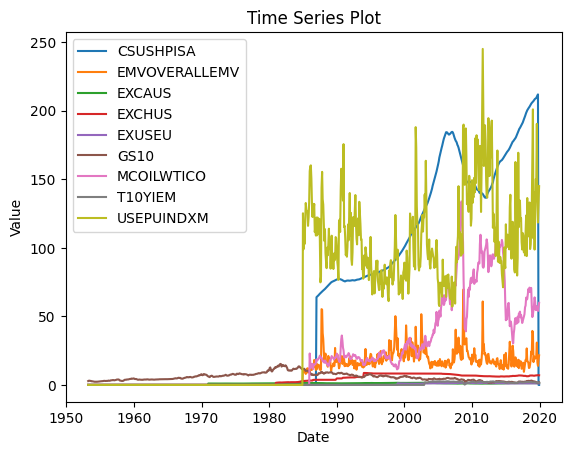

In [43]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))

for column in df_total.columns:
    if df_total[column].dtype in [float,int]:
        plt.plot(df_total.index, df_total[column], label=column)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

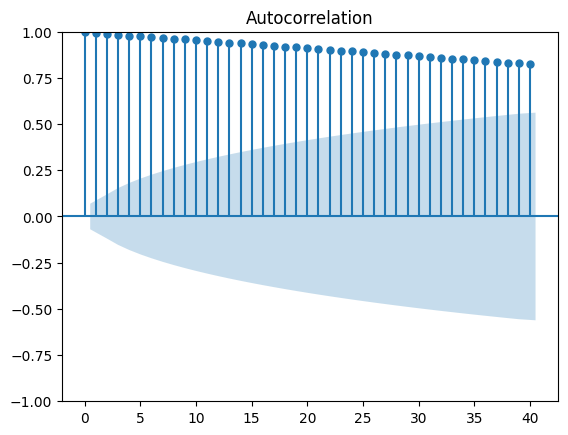

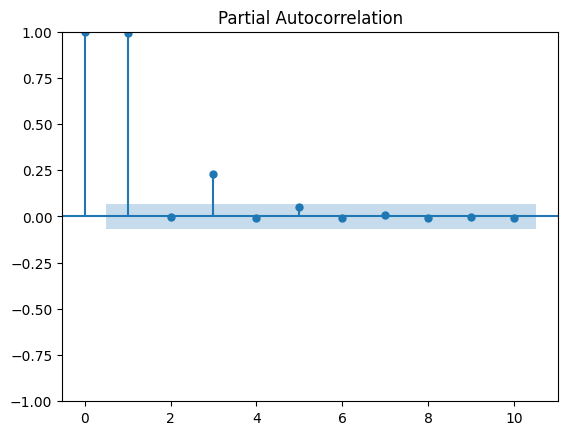

In [91]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_total.iloc[:,0], lags=40) 
plot_pacf(df_total.iloc[:,0], lags=10)

plt.show()

### ADF test for stationarity

In [93]:
from statsmodels.tsa.stattools import adfuller
adf=adfuller(df_total.iloc[:,0])
# test stat, pval < 0.05 then stationary else non stationary

(-1.5694196464864814,
 0.49893433825031475,
 0,
 800,
 {'1%': -3.438550508267578,
  '5%': -2.8651595688281253,
  '10%': -2.5686973890625},
 5443.097322367612)

## Modelling

In [41]:
mod_ses = sm.tsa.statespace.ExponentialSmoothing(df_train)
ses=mod_ses.fit()
forecast_ses=ses.forecast(6)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41592D+00    |proj g|=  5.95917D-01

At iterate    5    f=  2.27258D+00    |proj g|=  3.19647D-03

At iterate   10    f=  2.26998D+00    |proj g|=  1.09743D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     15      1     0     0   6.947D-06   2.270D+00
  F =   2.2698767342876476     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [94]:
# for long format


# from autots import AutoTS

# auto_model=AutoTS(3,"infer",max_generations=5,no_negatives=True,ensemble='simple')
# auto_model = auto_model.fit(
#     df_train,date_col='datetime',value_col='value',id_col='series_id'
# )
# prediction=auto_model.predict()
# forecasts_df = prediction.forecast

In [67]:
long=False
from autots import AutoTS

model = AutoTS(
    forecast_length=6,
    frequency='infer',
    prediction_interval=0.9,
    ensemble='horizontal',
    model_list="superfast",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    max_generations=4,
    num_validations=2,
    validation_method="backwards"
)
model.fit(
    df_train,
    date_col='datetime' if long else None,
    value_col='value' if long else None,
    id_col='series_id' if long else None,
)

prediction = model.predict()

Data frequency is: MS, used frequency is: MS
Model Number: 1 with model AverageValueNaive in generation 0 of 4
Model Number: 2 with model AverageValueNaive in generation 0 of 4
Model Number: 3 with model AverageValueNaive in generation 0 of 4
Model Number: 4 with model GLS in generation 0 of 4
Model Number: 5 with model GLS in generation 0 of 4
Model Number: 6 with model LastValueNaive in generation 0 of 4
Model Number: 7 with model LastValueNaive in generation 0 of 4
Model Number: 8 with model LastValueNaive in generation 0 of 4
Model Number: 9 with model LastValueNaive in generation 0 of 4
Model Number: 10 with model SeasonalNaive in generation 0 of 4
Model Number: 11 with model SeasonalNaive in generation 0 of 4
Model Number: 12 with model SeasonalNaive in generation 0 of 4
Model Number: 13 with model ConstantNaive in generation 0 of 4
Model Number: 14 with model SeasonalNaive in generation 0 of 4
Model Number: 15 with model SeasonalNaive in generation 0 of 4
Model Number: 16 with m

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.36689e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 130 with model LastValueNaive in generation 3 of 4
Model Number: 131 with model LastValueNaive in generation 3 of 4
Model Number: 132 with model ConstantNaive in generation 3 of 4
Model Number: 133 with model GLS in generation 3 of 4
Model Number: 134 with model ConstantNaive in generation 3 of 4
Model Number: 135 with model LastValueNaive in generation 3 of 4
Model Number: 136 with model SeasonalNaive in generation 3 of 4
New Generation: 4 of 4
Model Number: 137 with model GLS in generation 4 of 4
Model Number: 138 with model ConstantNaive in generation 4 of 4
Model Number: 139 with model AverageValueNaive in generation 4 of 4
Model Number: 140 with model AverageValueNaive in generation 4 of 4
Model Number: 141 with model LastValueNaive in generation 4 of 4
Model Number: 142 with model ConstantNaive in generation 4 of 4
Model Number: 143 with model AverageValueNaive in generation 4 of 4
Model Number: 144 with model GLS in generation 4 of 4
Model Number: 145 with model Se

In [72]:
print(model)

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'Horizontal', 'model_count': 6, 'model_metric': 'Score', 'models': {'3d08477a3c28abac14bc099611cbd1c2': {'Model': 'GLS', 'ModelParameters': '{}', 'TransformationParameters': '{"fillna": "rolling_mean", "transformations": {"0": "RollingMeanTransformer", "1": "StandardScaler", "2": "DifferencedTransformer", "3": "bkfilter"}, "transformation_params": {"0": {"fixed": true, "window": 3}, "1": {}, "2": {}, "3": {}}}'}, 'b39931e8ef5ca757dc95a411b1f8d5f1': {'Model': 'SeasonalityMotif', 'ModelParameters': '{"window": 10, "point_method": "mean", "distance_metric": "minkowski", "k": 20, "datepart_method": "simple"}', 'TransformationParameters': '{"fillna": "ffill", "transformations": {"0": "Slice", "1": "AlignLastValue", "2": "MinMaxScaler"}, "transformation_params": {"0": {"method": 0.5}, "1": {"rows": 1, "lag": 1, "method": "additive", "strength": 1.0, "first_value_only": false}, "2": {}}}'}, 'c591632ea193ae512398196f0f4ed71e'

In [70]:
model.results()

,ID,Model,ModelParameters,TransformationParameters,TransformationRuntime,FitRuntime,PredictRuntime,TotalRuntime,Ensemble,Exceptions,...,oda_weighted,dwae_weighted,mqae_weighted,ewmae_weighted,uwmse_weighted,smoothness_weighted,wasserstein_weighted,dwd_weighted,TotalRuntimeSeconds,Score
0,5e75ed52611fa9266c855f5876eb8720,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""fake_date"", ""transformations"": {""0...",0 days 00:00:00.054120,0 days 00:00:00.000178,0 days 00:00:00.000427,0 days 00:00:00.057091,0,NaN,...,0.43,4.71,6.70,31.13,62.43,0.18,5.85,3.10,0.06,27.69
1,4895867382ea9445684b6b64586d224b,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0 days 00:00:00.023608,0 days 00:00:00.000185,0 days 00:00:00.000443,0 days 00:00:00.026555,0,NaN,...,0.26,5.54,7.45,35.25,73.97,0.02,6.39,3.40,0.03,30.49
2,d8bd60351c03557d2b76a1f72be762ff,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""rolling_mean_24"", ""transformations...",0 days 00:00:00.002615,0 days 00:00:00.000150,0 days 00:00:00.000491,0 days 00:00:00.005489,0,NaN,...,0.52,14.88,13.11,60.92,6117.86,0.95,63.02,17.62,0.01,83.41
3,36ca223faaa43b7034902862aafc1026,GLS,{},"{""fillna"": ""rolling_mean"", ""transformations"": ...",0 days 00:00:00.005588,0 days 00:00:00.000413,0 days 00:00:00.005184,0 days 00:00:00.013272,0,NaN,...,0.70,3.09,3.67,16.12,127.62,0.48,4.60,2.37,0.01,22.34
4,544ca75f482ead3906feef95649c29ab,GLS,{},"{""fillna"": ""median"", ""transformations"": {""0"": ...",0 days 00:00:00.026664,0 days 00:00:00.000492,0 days 00:00:00.005044,0 days 00:00:00.035838,0,NaN,...,0.41,5.48,3.53,18.05,302.35,0.69,33.12,8.57,0.04,74.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,39773b6936c748ae8b025864e78a4cb7,ConstantNaive,"{""constant"": 0}","{""fillna"": ""rolling_mean"", ""transformations"": ...",0 days 00:00:00.002192,0 days 00:00:00.000016,0 days 00:00:00.000135,0 days 00:00:00.004498,0,NaN,...,0.33,4.16,2.61,13.70,28.94,0.02,8.45,4.01,0.00,25.26
223,c591632ea193ae512398196f0f4ed71e,LastValueNaive,{},"{""fillna"": ""mean"", ""transformations"": {""0"": ""S...",0 days 00:00:00.003531,0 days 00:00:00.000303,0 days 00:00:00.000423,0 days 00:00:00.005880,0,NaN,...,0.31,6.07,4.94,24.16,189.37,0.86,21.55,3.06,0.01,33.81
224,4feddfdfc4b136e9aacb1d412b1a94a7,GLS,{},"{""fillna"": ""rolling_mean_24"", ""transformations...",0 days 00:00:00.013445,0 days 00:00:00.000535,0 days 00:00:00.005348,0 days 00:00:00.021201,0,NaN,...,0.59,6.23,9.67,77.29,313.93,0.27,7.43,2.77,0.02,43.25
225,4185e1804ea4be7e19211b2d5cbf71ad,AverageValueNaive,"{""method"": ""Weighted_Mean"", ""window"": 420}","{""fillna"": ""rolling_mean"", ""transformations"": ...",0 days 00:00:00.003535,0 days 00:00:00.000236,0 days 00:00:00.000487,0 days 00:00:00.007979,0,NaN,...,0.26,12.37,10.16,45.07,3335.54,0.83,53.73,12.06,0.01,61.94


In [71]:
model.results("validation")

,ID,Model,ModelParameters,TransformationParameters,Ensemble,Runs,smape,mae,rmse,made,...,dwd_weighted,matse_weighted,containment_weighted,contour_weighted,TotalRuntimeSeconds,Score,lowest_series_mape,lowest_series_mape_name,highest_series_mape,highest_series_mape_name
0,00c999ad50ad0135fd89729fc0729628,LastValueNaive,{},"{""fillna"": ""ffill_mean_biased"", ""transformatio...",0,1,15.85,8.73,9.67,1.29,...,2.32,0.19,0.70,0.52,0.06,37.44,0.52,CSUSHPISA,219.74,EMVOVERALLEMV
1,0a31536c33f9121908e80e1ba8429af3,LastValueNaive,{},"{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0,1,16.19,9.85,10.55,1.03,...,3.08,0.20,0.20,0.52,0.02,35.98,1.36,CSUSHPISA,227.54,EMVOVERALLEMV
2,0c99895c85ca5387d4b441baa298a92f,LastValueNaive,{},"{""fillna"": ""zero"", ""transformations"": {""0"": ""S...",0,1,13.10,5.44,6.40,1.35,...,2.40,0.10,0.70,0.50,0.07,29.05,1.58,CSUSHPISA,65.31,EMVOVERALLEMV
3,0e241ed6cce745f1bf535601478ab9a8,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""fake_date"", ""transformations"": {""0...",0,1,98.65,5.62,6.91,6.02,...,29.55,0.53,0.54,0.50,0.08,176.59,3.36,CSUSHPISA,356.06,T10YIEM
4,0eeffdab3d601eeff4cf6fd43ae9dcc9,GLS,{},"{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0,1,7.55,4.65,6.46,1.14,...,1.94,0.07,0.96,0.54,0.02,56.25,1.19,CSUSHPISA,53.63,USEPUINDXM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,f81b37987b2ec316d13ea11c7c4e3aa2,LastValueNaive,{},"{""fillna"": ""rolling_mean_24"", ""transformations...",0,1,9.56,4.63,6.05,1.27,...,2.16,0.07,0.89,0.63,0.02,21.12,0.91,CSUSHPISA,51.29,T10YIEM
151,f884194299ff887ca68cde3c85ab7290,LastValueNaive,{},"{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0,1,13.66,7.58,8.27,1.01,...,3.40,0.15,0.76,0.63,0.01,31.22,1.67,EXCAUS,169.52,EMVOVERALLEMV
152,f8b9b0776bcc87732cc70cc9f90f1a53,GLS,{},"{""fillna"": ""median"", ""transformations"": {""0"": ...",0,1,23.28,10.32,11.39,3.65,...,14.79,0.23,1.00,0.59,0.01,76.44,17.48,MCOILWTICO,82.93,CSUSHPISA
153,f9423cc80e0a6ac8e289bcd1b8c334fa,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""fake_date"", ""transformations"": {""0...",0,3,11.01,4.82,5.76,1.04,...,3.28,0.10,0.65,0.57,0.06,23.63,2.72,CSUSHPISA,164.57,EMVOVERALLEMV


<Axes: title={'center': 'CSUSHPISA with model SeasonalityMotif'}>

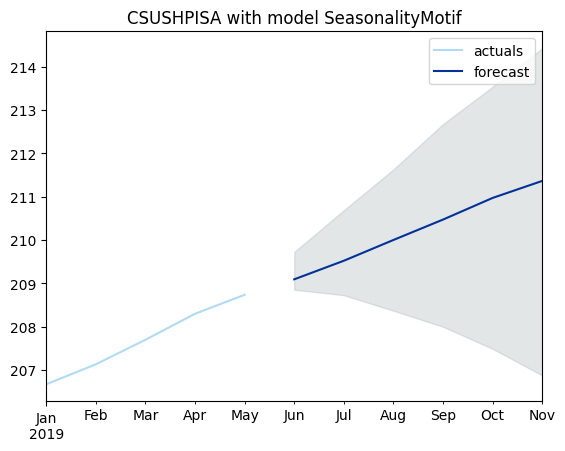

In [52]:
# plot a sample
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                start_date="2019-01-01")


In [49]:
# Print the details of the best model
print(model)

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'Horizontal', 'model_count': 8, 'model_metric': 'Score-max', 'models': {'c6de0f503699f4de49b9c95b2e4abe87': {'Model': 'VAR', 'ModelParameters': '{"regression_type": null, "maxlags": 15, "ic": "aic"}', 'TransformationParameters': '{"fillna": "zero", "transformations": {"0": "RollingMeanTransformer", "1": "QuantileTransformer", "2": "RollingMeanTransformer"}, "transformation_params": {"0": {"fixed": true, "window": 10}, "1": {"output_distribution": "uniform", "n_quantiles": 257}, "2": {"fixed": false, "window": 10}}}'}, '5298412602fb6300d1a018b89012e43b': {'Model': 'VAR', 'ModelParameters': '{"regression_type": null, "maxlags": 15, "ic": "fpe"}', 'TransformationParameters': '{"fillna": "ffill", "transformations": {"0": "MinMaxScaler", "1": "RegressionFilter"}, "transformation_params": {"0": {}, "1": {"sigma": 2, "rolling_window": 90, "run_order": "season_first", "regression_params": {"regression_model": {"model": "Elast

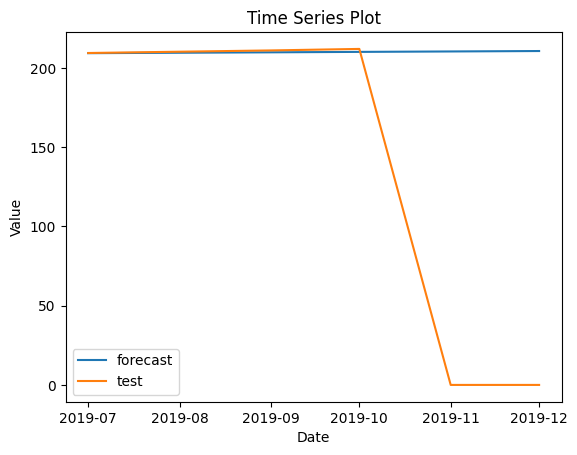

In [65]:
# point forecasts dataframe
forecasts_df = prediction.forecast
plt.plot(forecasts_df.index, forecasts_df['CSUSHPISA'], label='forecast')
plt.plot(df_test.index, df_test['CSUSHPISA'], label='test')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [68]:
model.best_model_name,
model.best_model_params,
model.best_model_transformation_params

{}

### Accuracy metrics

In [11]:
def forecast_accuracy(forecast, actual):
    forecast,actual= np.array(forecast), np.array(actual) 
    try:
        mape = np.mean(np.abs((actual - forecast) / actual))*100
    except:
        mape = 200 # MAPE
    mae = mean_absolute_error(actual,forecast)    # MAE
    rmse = (mean_squared_error(actual,forecast))**.5  # RMSE
#     MASE=mase(actual,forecast)
    r2=r2_score(actual,forecast)                   # r-squared
    rtae=(mean_absolute_error(actual,forecast)/np.mean(abs(actual)))
    return({'mape':mape, 'mae': mae, 
            'rmse':rmse,
             'r2':r2,
            'rtae':rtae
           })

pre processing done!


In [68]:
df_train

,value,series_id,series_name
1953-04-01,2.83,GS10,10-Year Treasury Constant Maturity Rate
1953-05-01,3.05,GS10,10-Year Treasury Constant Maturity Rate
1953-06-01,3.11,GS10,10-Year Treasury Constant Maturity Rate
1953-07-01,2.93,GS10,10-Year Treasury Constant Maturity Rate
1953-08-01,2.95,GS10,10-Year Treasury Constant Maturity Rate
...,...,...,...
2019-11-01,18.76,EMVOVERALLEMV,Equity Market Volatility Tracker Overall
2019-11-01,1.64,T10YIEM,10 Year Breakeven Inflation Rate
2019-11-01,131.78,USEPUINDXM,Economic Policy Uncertainty Index for United S...
2019-12-01,1.86,GS10,10-Year Treasury Constant Maturity Rate
